<a href="https://colab.research.google.com/github/emcgeever-husky/Econ3916/blob/main/Lab%204/Descriptive%20Statistics%20%26%20Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initializing

In [46]:
# libraries & housing data
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [47]:
# Take in Data
data = fetch_california_housing(as_frame=True)
df = data.frame

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


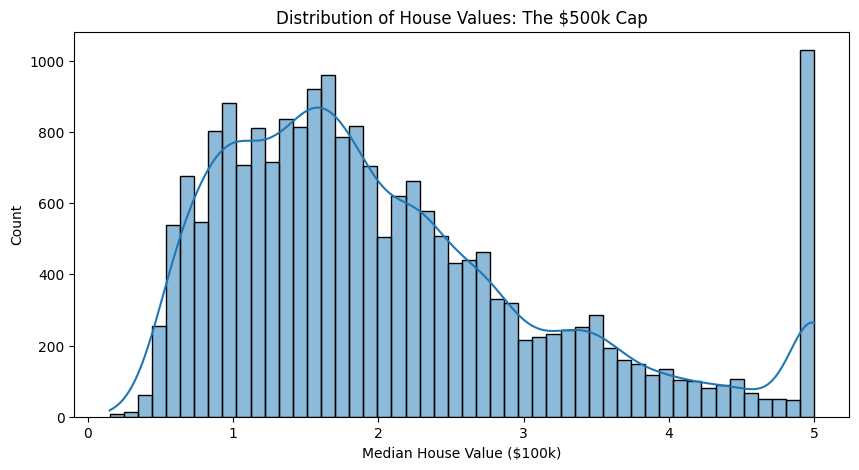

In [48]:
# Observing "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

## Breaking Down Outliers

In [49]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


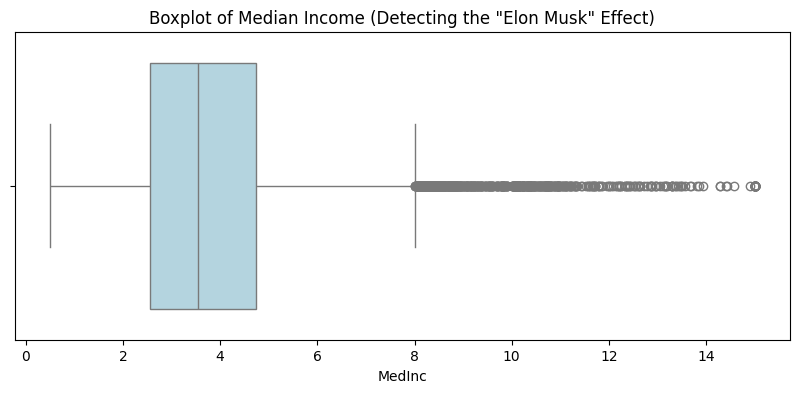

In [50]:
## Visualize outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [51]:
## Multivariate Anomolies via Isolation Forest
# contamination=0.05 -- estimates ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# variables to analyze (Income, House Age, Average Rooms)
variables = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[variables])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


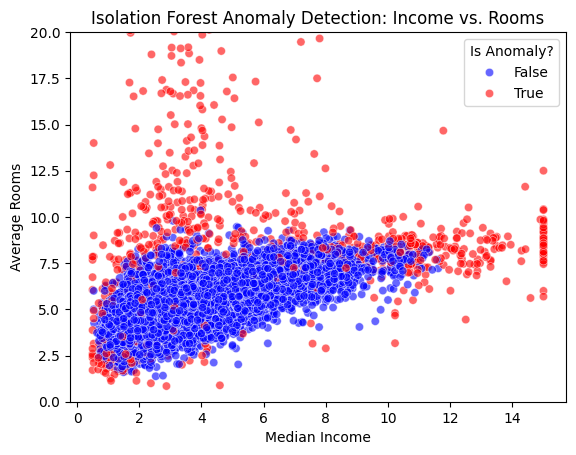

In [52]:
# Visualize
# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

## Understanding the Difference between Normal and Anomolous Data


In [53]:
## Isolating Anolomies and Analysizing difference
df_normal = df[df['outlier_iso'] == False]
df_outlier = df[df['outlier_iso'] == True]

In [54]:
# Mean & Median
summary_stats = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_Mean': [
        df_normal['MedInc'].mean(),
        df_outlier['MedInc'].mean()
    ],
    'MedInc_Median': [
        df_normal['MedInc'].median(),
        df_outlier['MedInc'].median()
    ],
    'MedHouseVal_Mean': [
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'MedHouseVal_Median': [
        df_normal['MedHouseVal'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

In [55]:
# Standard Deviations & Median Absolute Volatility (MAD)
def mad(series):
    return np.median(np.abs(series - np.median(series)))

volatility = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_STD': [
        df_normal['MedInc'].std(),
        df_outlier['MedInc'].std()
    ],
    'MedInc_MAD': [
        mad(df_normal['MedInc']),
        mad(df_outlier['MedInc'])
    ],
    'MedHouseVal_STD': [
        df_normal['MedHouseVal'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MedHouseVal_MAD': [
        mad(df_outlier['MedHouseVal']),
        mad(df_outlier['MedHouseVal'])
    ]
})

In [56]:
# 'Inequality Wedge' -- Summary Stats
inequality_wedge = pd.DataFrame({
    'Metric': ['MedInc', 'MedHouseVal'],
    'Mean': [
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

inequality_wedge['Inequality_Wedge'] = (
    inequality_wedge['Mean'] - inequality_wedge['Median']
)

print("=== Inequality Wedge (Outliers Only) ===")
print(inequality_wedge)



=== Inequality Wedge (Outliers Only) ===
        Metric      Mean   Median  Inequality_Wedge
0       MedInc  5.790782  4.25695          1.533832
1  MedHouseVal  2.668172  2.05700          0.611172


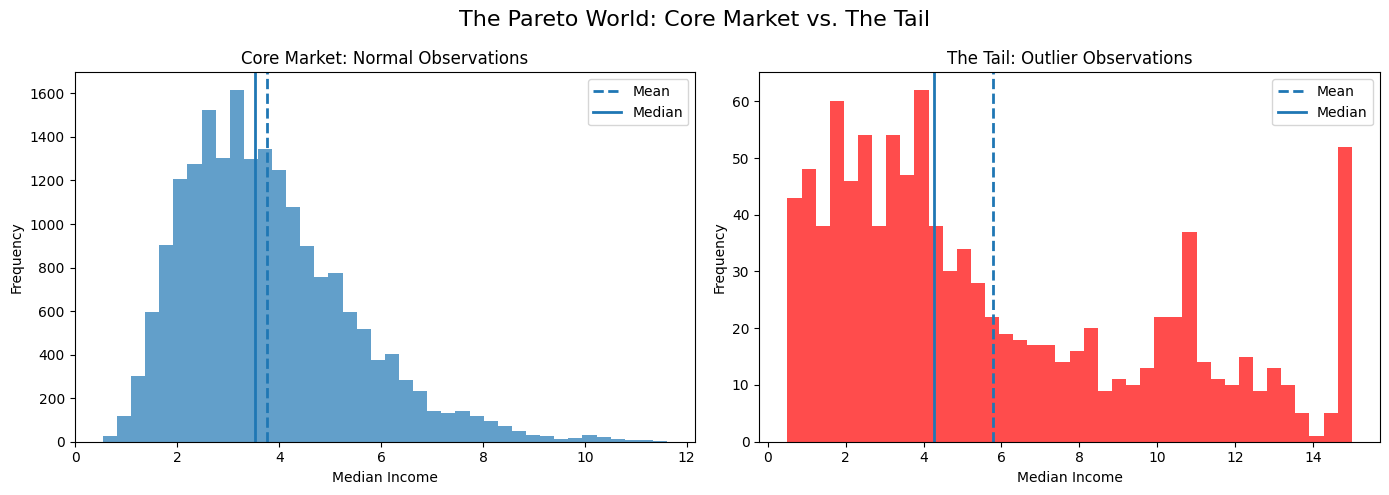

In [57]:
## Visualizing the difference
plt.figure(figsize=(14, 5))


## Normal
plt.subplot(1, 2, 1)
plt.hist(df_normal['MedInc'], bins=40, alpha=0.7)
plt.title('Core Market: Normal Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')


mean_normal = df_normal['MedInc'].mean()
median_normal = df_normal['MedInc'].median()

plt.axvline(mean_normal, linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_normal, linestyle='-', linewidth=2, label='Median')

plt.legend()

### Outlier
plt.subplot(1, 2, 2)
plt.hist(df_outlier['MedInc'], bins=40, alpha=0.7, color = "red")
plt.title('The Tail: Outlier Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')


mean_outlier = df_outlier['MedInc'].mean()
median_outlier = df_outlier['MedInc'].median()

plt.axvline(mean_outlier, linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_outlier, linestyle='-', linewidth=2, label='Median')

plt.suptitle('The Pareto World: Core Market vs. The Tail', fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

In [58]:
## Print comprehensive summary statistics
## Comparative Forensics Report: Normal vs Outlier Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Split the data into two DataFrames
df_normal = df[df['outlier_iso'] == False]
df_outlier = df[df['outlier_iso'] == True]

# 2. Calculate Mean and Median for both groups
summary_stats = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_Mean': [
        df_normal['MedInc'].mean(),
        df_outlier['MedInc'].mean()
    ],
    'MedInc_Median': [
        df_normal['MedInc'].median(),
        df_outlier['MedInc'].median()
    ],
    'MedHouseVal_Mean': [
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'MedHouseVal_Median': [
        df_normal['MedHouseVal'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

# 3. Calculate Standard Deviation vs MAD for volatility
def mad(series):
    return np.median(np.abs(series - np.median(series)))

volatility = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_STD': [
        df_normal['MedInc'].std(),
        df_outlier['MedInc'].std()
    ],
    'MedInc_MAD': [
        mad(df_normal['MedInc']),
        mad(df_outlier['MedInc'])
    ],
    'MedHouseVal_STD': [
        df_normal['MedHouseVal'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MedHouseVal_MAD': [
        mad(df_normal['MedHouseVal']),
        mad(df_outlier['MedHouseVal'])
    ]
})

# 4. Calculate Inequality Wedge (Mean - Median) for outliers
inequality_wedge = pd.DataFrame({
    'Metric': ['MedInc', 'MedHouseVal'],
    'Mean': [
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

inequality_wedge['Inequality_Wedge'] = (
    inequality_wedge['Mean'] - inequality_wedge['Median']
)

# Print Comparative Forensics Report
print("\n" + "="*70)
print("COMPARATIVE FORENSICS REPORT: NORMAL vs OUTLIER OBSERVATIONS")
print("="*70)

print(f"\nSAMPLE SIZES")
print("-" * 70)
print(f"Normal Observations:  {len(df_normal):>8,}")
print(f"Outlier Observations: {len(df_outlier):>8,}")
print(f"Total:                {len(df):>8,}")

print(f"\nCENTRAL TENDENCY COMPARISON")
print("-" * 70)
print(f"{'Metric':<20} {'Group':<10} {'Mean':>12} {'Median':>12}")
print("-" * 70)
print(f"{'MedInc':<20} {'Normal':<10} {df_normal['MedInc'].mean():>12.3f} {df_normal['MedInc'].median():>12.3f}")
print(f"{'MedInc':<20} {'Outlier':<10} {df_outlier['MedInc'].mean():>12.3f} {df_outlier['MedInc'].median():>12.3f}")
print(f"{'MedHouseVal':<20} {'Normal':<10} {df_normal['MedHouseVal'].mean():>12.3f} {df_normal['MedHouseVal'].median():>12.3f}")
print(f"{'MedHouseVal':<20} {'Outlier':<10} {df_outlier['MedHouseVal'].mean():>12.3f} {df_outlier['MedHouseVal'].median():>12.3f}")

print(f"\nVOLATILITY ANALYSIS (STD vs MAD)")
print("-" * 70)
print(f"{'Metric':<20} {'Group':<10} {'Std Dev':>12} {'MAD':>12}")
print("-" * 70)
print(f"{'MedInc':<20} {'Normal':<10} {df_normal['MedInc'].std():>12.3f} {mad(df_normal['MedInc']):>12.3f}")
print(f"{'MedInc':<20} {'Outlier':<10} {df_outlier['MedInc'].std():>12.3f} {mad(df_outlier['MedInc']):>12.3f}")
print(f"{'MedHouseVal':<20} {'Normal':<10} {df_normal['MedHouseVal'].std():>12.3f} {mad(df_normal['MedHouseVal']):>12.3f}")
print(f"{'MedHouseVal':<20} {'Outlier':<10} {df_outlier['MedHouseVal'].std():>12.3f} {mad(df_outlier['MedHouseVal']):>12.3f}")

print(f"\nINEQUALITY WEDGE (Outliers Only)")
print("-" * 70)
print(f"{'Metric':<20} {'Mean':>12} {'Median':>12} {'Wedge':>12}")
print("-" * 70)
for _, row in inequality_wedge.iterrows():
    print(f"{row['Metric']:<20} {row['Mean']:>12.3f} {row['Median']:>12.3f} {row['Inequality_Wedge']:>12.3f}")

print("\n" + "="*70 + "\n")



COMPARATIVE FORENSICS REPORT: NORMAL vs OUTLIER OBSERVATIONS

SAMPLE SIZES
----------------------------------------------------------------------
Normal Observations:    19,608
Outlier Observations:    1,032
Total:                  20,640

CENTRAL TENDENCY COMPARISON
----------------------------------------------------------------------
Metric               Group              Mean       Median
----------------------------------------------------------------------
MedInc               Normal            3.770        3.516
MedInc               Outlier           5.791        4.257
MedHouseVal          Normal            2.037        1.789
MedHouseVal          Outlier           2.668        2.057

VOLATILITY ANALYSIS (STD vs MAD)
----------------------------------------------------------------------
Metric               Group           Std Dev          MAD
----------------------------------------------------------------------
MedInc               Normal            1.641        1.032
MedInc 

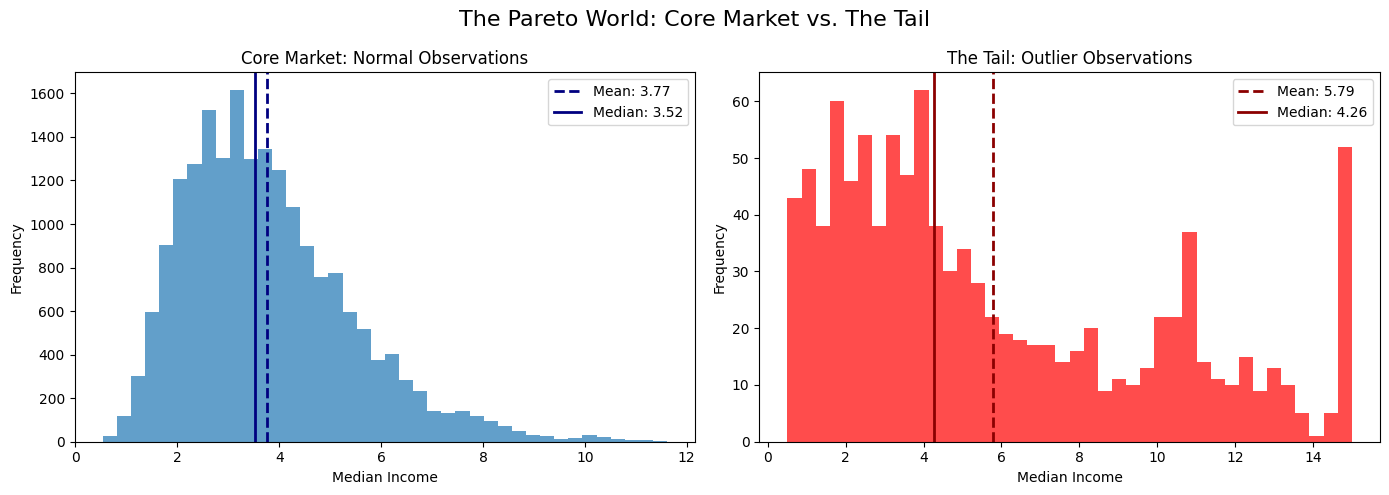

In [60]:
## Visualizing the difference
plt.figure(figsize=(14, 5))

## Normal
plt.subplot(1, 2, 1)
plt.hist(df_normal['MedInc'], bins=40, alpha=0.7)
plt.title('Core Market: Normal Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

mean_normal = df_normal['MedInc'].mean()
median_normal = df_normal['MedInc'].median()

plt.axvline(mean_normal, linestyle='--', linewidth=2, label=f'Mean: {mean_normal:.2f}', color='navy')
plt.axvline(median_normal, linestyle='-', linewidth=2, label=f'Median: {median_normal:.2f}', color='navy')
plt.legend()

### Outlier
plt.subplot(1, 2, 2)
plt.hist(df_outlier['MedInc'], bins=40, alpha=0.7, color="red")
plt.title('The Tail: Outlier Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

mean_outlier = df_outlier['MedInc'].mean()
median_outlier = df_outlier['MedInc'].median()

plt.axvline(mean_outlier, linestyle='--', linewidth=2, label=f'Mean: {mean_outlier:.2f}', color='darkred')
plt.axvline(median_outlier, linestyle='-', linewidth=2, label=f'Median: {median_outlier:.2f}', color='darkred')
plt.legend()

plt.suptitle('The Pareto World: Core Market vs. The Tail', fontsize=16)
plt.tight_layout()
plt.show()